#  1. Importações e dados
.

In [1]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor


sns.set_theme()

/home/fause/ML-Transportes/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Carregando os dados
df = pd.read_excel('/home/fause/ML-Transportes/Dados/analiseestatistica_indicadores2.xlsx')

In [3]:
# Pré-processamento
df['km_rodovias_federais'] = df['km_rodovias_federais'].fillna(0)
df['area_km2'] = df['area_km2'].fillna(df['area_km2'].median())
#df = pd.get_dummies(df, columns=['UF', 'Estado'], drop_first=True)
df['Integrado ao SNT'] = df['Integrado ao SNT'].map({'Sim': 1, 'Não': 0})
df['log_sinistros'] = np.log1p(df['Sinistros'])  # log(1 + x)



# 2. Definir target (y) e features (X)

In [4]:
features = [
    'PIB per capita', 'Tx de Alfabetização +15 anos',
    'Taxa de Admissão em Empregos', 'IDHM',
    'Taxa de Óbitos/100 mil habitantes', '% de Óbitos/Sinistros',
    'area_km2', 'km_rodovias_federais', 'Integrado ao SNT'
] 

X = df[features]
y = df['log_sinistros']


 # 3. Pré-processamento

In [5]:
# Separar treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Imputação e normalização
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)


# 4. Modelos de regressão

In [6]:
print("Sinistros (min, max, média, mediana):")
print(df['Sinistros'].min(), df['Sinistros'].max(), df['Sinistros'].mean(), df['Sinistros'].median())


Sinistros (min, max, média, mediana):
0 482959 1164.748473967684 107.0


In [7]:
# Regressão Linear

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred = lr.predict(X_test_scaled)

print("MSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))


MSE: 1.9399833430296514
R²: 0.5301275951154404


In [8]:
# b Random Forest Regressor

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred = rf.predict(X_test_scaled)

print("MSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

MSE: 0.5432071244195203
R²: 0.8684328714375332


In [9]:
# c) XGBoost Regressor

from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators=300, learning_rate=0.05, random_state=42)
xgb.fit(X_train_scaled, y_train)
y_pred = xgb.predict(X_test_scaled)

print("MSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

MSE: 0.5146224988804874
R²: 0.8753561920902636


| Modelo              | Métrica | Antes do log            | Depois do log          | Interpretação                        |
|---------------------|---------|------------------------|-----------------------|------------------------------------|
| Regressão Linear    | R²      | 0.049                  | 0.530                 | Melhora significativa, ainda moderado |
|                     | MSE     | 69.328.881             | 1.940                 | Diminuição enorme do erro (escala log) |
| Random Forest       | R²      | 0.503                  | 0.868                 | Modelo muito mais explicativo       |
|                     | MSE     | 36.199.488             | 0.543                 | Queda expressiva no erro             |
| XGBoost Regressor   | R²      | 0.517                  | 0.875                 | Melhor desempenho geral              |
|                     | MSE     | 35.184.476             | 0.515                 | Melhor erro, modelo mais preciso     |


In [10]:
import shap

explainer = shap.Explainer(model, X_test_scaled)
shap_values = explainer(X_test_scaled)

shap.plots.beeswarm(shap_values, feature_names=X.columns)


NameError: name 'model' is not defined

 97%|=================== | 1079/1114 [00:26<00:00]       

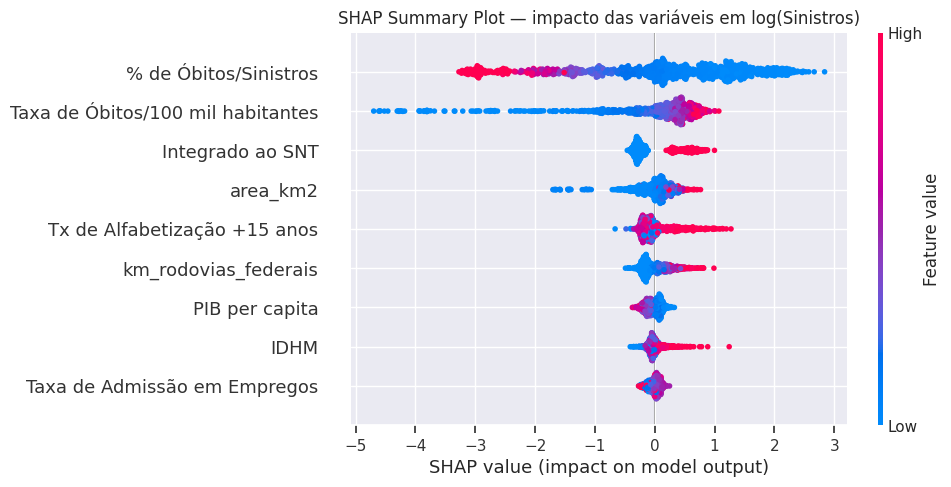

In [ ]:
import pandas as pd

# Supondo que você tenha um DataFrame original X com colunas:
X_test_df = pd.DataFrame(X_test_scaled, columns=X.columns)

# Criar explainer usando o DataFrame
explainer = shap.Explainer(xgb, X_test_df)

# Calcular valores SHAP
shap_values = explainer(X_test_df)

# Agora plotar sem passar argumento 'features'
plt.title("SHAP Summary Plot — impacto das variáveis em log(Sinistros)")
shap.plots.beeswarm(shap_values)
plt.show()


In [ ]:
# 4. Predição do modelo (log scale)
y_pred_log = xgb.predict(X_test_scaled)

# 5. Converter para escala real (sinistros)
y_pred_real = np.expm1(y_pred_log)
y_test_real = np.expm1(y_test)

# 6. Avaliar performance na escala real
rmse_real = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
r2_real = r2_score(y_test_real, y_pred_real)

print(f"RMSE na escala real: {rmse_real:.2f}")
print(f"R² na escala real: {r2_real:.2f}")

# 7. Criar dataframe para análise detalhada
df_resultados = pd.DataFrame({
    'Sinistros_Real_Observado': y_test_real,
    'Sinistros_Real_Previsto': y_pred_real,
    'Erro_Absoluto': np.abs(y_test_real - y_pred_real),
    'Erro_Percentual': np.abs(y_test_real - y_pred_real) / (y_test_real + 1e-6) * 100
})

print("\nTop 10 municípios com maior erro absoluto:")
print(df_resultados.sort_values('Erro_Absoluto', ascending=False).head(10))


RMSE na escala real: 6571.30
R² na escala real: 0.41

Top 10 municípios com maior erro absoluto:
      Sinistros_Real_Observado  Sinistros_Real_Previsto  Erro_Absoluto   
5417                  209954.0             26319.275391  183634.724609  \
4005                  175547.0             68946.125000  106600.875000   
3479                   29636.0              2195.506592   27440.493408   
5180                    7939.0             26392.269531   18453.269531   
3375                   24988.0              6921.638184   18066.361816   
3112                   21163.0              5965.617188   15197.382812   
1163                   16762.0              3533.031738   13228.968262   
4299                    3412.0             16351.031250   12939.031250   
4463                    4210.0             14916.788086   10706.788086   
2445                    9487.0             17840.285156    8353.285156   

      Erro_Percentual  
5417        87.464266  
4005        60.724977  
3479        92.5


Análise SHAP detalhada para o município índice 0:


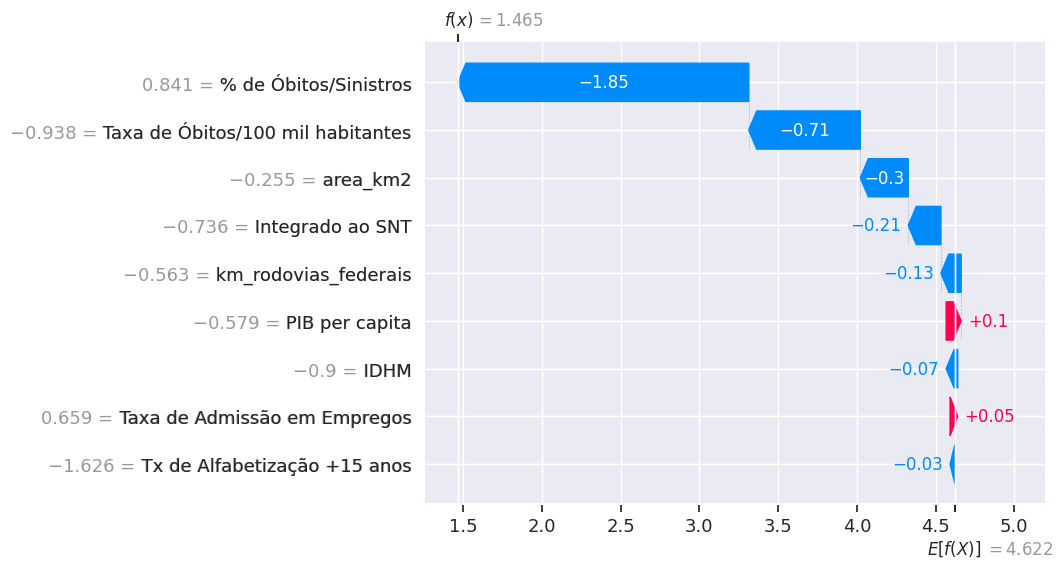


Importância média absoluta das features (SHAP):
                             Feature  Mean_Abs_SHAP
5              % de Óbitos/Sinistros       1.167993
4  Taxa de Óbitos/100 mil habitantes       0.603879
8                   Integrado ao SNT       0.353110
6                           area_km2       0.208609
1       Tx de Alfabetização +15 anos       0.194899
7               km_rodovias_federais       0.185742
0                     PIB per capita       0.100534
3                               IDHM       0.089660
2       Taxa de Admissão em Empregos       0.068103


In [ ]:
# 8. Análise SHAP detalhada para um município específico (exemplo: índice 0)
ind = 0  # escolha outro índice conforme quiser
print(f"\nAnálise SHAP detalhada para o município índice {ind}:")
shap.plots.waterfall(shap_values[ind])

# 9. Importância média absoluta das features
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
# Se X_test_scaled for DataFrame, use X_test_scaled.columns, senão, substitua pelos nomes das features
feature_names = X.columns if hasattr(X, "columns") else [f'Feature_{i}' for i in range(X_test_scaled.shape[1])]
shap_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Mean_Abs_SHAP': mean_abs_shap
}).sort_values('Mean_Abs_SHAP', ascending=False)

print("\nImportância média absoluta das features (SHAP):")
print(shap_importance_df)


# avaliação dos modelos


In [ ]:
# #%% Avaliação dos modelos
# def avaliar_modelo(y_true, y_pred, nome):
#     print(f"\n🔎 Avaliação do modelo: {nome}")
#     print("MAE:", mean_absolute_error(y_true, y_pred))
#     print("MSE:", mean_squared_error(y_true, y_pred))
#     print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
#     print("R²:", r2_score(y_true, y_pred))

# avaliar_modelo(y_test, y_pred_rf, "Random Forest")
# avaliar_modelo(y_test, y_pred_lr, "Regressão Linear")
# avaliar_modelo(y_test, y_pred_xgb, "XGBoost")

 # 5. Importância das variáveis

In [ ]:
# importances = rf.feature_importances_
# feature_importance = pd.DataFrame({'feature': features, 'importance': importances})
# feature_importance = feature_importance.sort_values('importance', ascending=False)

# plt.figure(figsize=(10, 6))
# sns.barplot(x='importance', y='feature', data=feature_importance)
# plt.title('Importância das Features para Previsão de Sinistros')
# plt.tight_layout()
# plt.show()


# Correlação com Sinistros
Você pode também entender as variáveis mais associadas com Sinistros:



In [ ]:

# Correlação com Sinistros
# corr_matrix = df[features + ['Sinistros']].corr()
# print("\nCorrelação com Sinistros:\n")
# print(corr_matrix['Sinistros'].sort_values(ascending=False))

# # Heatmap
# plt.figure(figsize=(10,8))
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
# plt.title("Correlação entre variáveis")
# plt.show()